[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution

## Review

In module 3, we went in-depth on `human-in-the loop`, showing 3 common use-cases:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

## Goals

This module will build on `human-in-the-loop` as well as the `memory` concepts discussed in module 2.

We will dive into `multi-agent` workflows and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

We'll start with [parallelization](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches).

## Fan out and fan in

Let's build a simple linear graph that over-writes the state at each step.

In [31]:
%%capture --no-stderr
%pip install -U langgraph langgraph_tavily arxiv langchain_anthropic langchain_community langgraph_sdk

In [32]:
from dotenv import load_dotenv
load_dotenv('studio/.env')

True

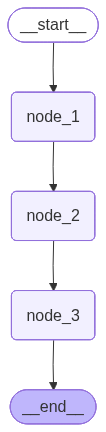

In [33]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `node_1`, `node_2`, and `node_3` all execute sequentially.

Each node overwrites the prior value of `foo`.

In [34]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---
---Node 3---


{'foo': 4}

## Reducers

In the above, each node overwrites the state key for `foo`.

But, we can use [Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to accumulate to the value of the `foo` key.

Let's add a list of integers.

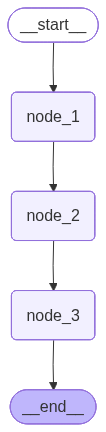

In [35]:
from typing import Annotated
from operator import add

class State(TypedDict):
    # Annotate our state with a reducer
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][0] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 2, 2]}

## Parallelization 

Often, we'd like nodes to operate in parallel. 
 
This is possible if nodes do not have any path dependencies between them. 

We can simply connect them to the same starting node.

This is a form of `fan out` and `fan in`, where we execute many steps in parallel and aggregate the outputs.

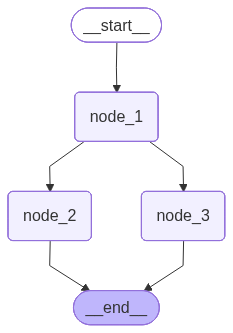

In [37]:
from typing import Annotated
from operator import add

class State(TypedDict):
    # Annotate our state with a reducer
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][0] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 2, 2]}

You can see that `node_2` and `node_3` are now run in parallel.

The results from both are reduced (`added`) to the output.

## Longer chains

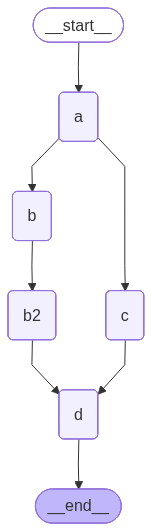

In [39]:
from operator import add 
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> dict:
        print(f"Adding {self._value} to {state['aggregate']} ")
        return {"aggregate": [self._value]}

builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`. 

In [40]:
graph.invoke({"aggregate": []})

Adding I'm A to [] 
Adding I'm B to ["I'm A"] 
Adding I'm C to ["I'm A"] 
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"] 
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"] 


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## Example: RAG

One useful real-world application of parallel execution is for RAG.

We can retrieve documents from different sources in parallel, and then aggregate them before generation.

In [41]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-haiku-4-5-20251001", temperature=0)

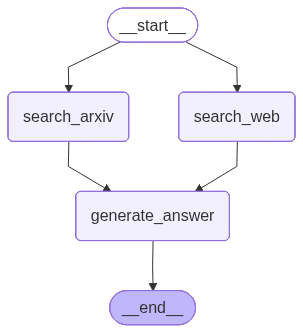

In [42]:
from operator import add 
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, add]

from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import ArxivLoader
from langchain_tavily import TavilySearch  # updated since filming

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearch(max_results=3)
    data = tavily_search.invoke({"query": state['question']})
    search_docs = data.get("results", data)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_arxiv(state):
    
    """ Retrieve docs from ArXiv """

    # Search
    # ArxivLoader loads documents by searching ArXiv
    # It returns the top results based on the query
    search_docs = ArxivLoader(query=state['question'], 
                              load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata.get("entry_id", doc.metadata.get("Entry ID", "arxiv"))}" title="{doc.metadata.get("Title", "")}">\n{doc.page_content[:1000]}...\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_arxiv", search_arxiv)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_arxiv")
builder.add_edge(START, "search_web")
builder.add_edge("search_arxiv", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
result = graph.invoke({"question": "How were Nvidia's Q2 2025 earnings"})
result['answer'].content

"# Nvidia's Q2 2025 Earnings\n\nBased on the provided context, here are the key highlights from Nvidia's Q2 2025 earnings:\n\n## Financial Performance\n- **Revenue**: $46.74 billion, beating analyst estimates\n- **EPS (Earnings Per Share)**: $1.04-$1.05 (adjusted), exceeding the forecast of $1.01\n- **Earnings Surprise**: 2.97% beat on EPS\n\n## Key Takeaways\n\n1. **Strong Growth Continuation**: Sales growth remained above 50% for the quarter, indicating sustained demand for AI infrastructure\n\n2. **China Challenges**: \n   - A custom-built processor for China (H20 chips) resulted in $4.5 billion in write-downs\n   - Could have added $8 billion in Q2 sales if commercially available\n\n3. **Robotics Division Growth**: \n   - Generated $586 million in sales\n   - Represented 69% annual growth, though still a small part of overall business\n\n4. **Future Outlook**: \n   - Nvidia's successor to Blackwell, called **Rubin**, is on track for volume production in 2026\n   - The company expec

## Using with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

In [44]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangSmith Studio is currently not supported on Google Colab")

In [45]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [46]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2025 earnings?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    if event.data is not None:
        answer = event.data.get('answer', None)
        if answer:
            print(answer['content'])

# Nvidia Q2 2025 Earnings

Based on the provided context, here are the key highlights from Nvidia's Q2 2025 earnings:

## Financial Performance
- **Revenue**: $46.74 billion, beating analyst estimates
- **EPS (Earnings Per Share)**: $1.04-$1.05 (adjusted), exceeding the forecast of $1.01
- **Earnings Surprise**: 2.97% beat on EPS

## Key Takeaways
- Nvidia **exceeded expectations** for the second consecutive quarter
- **Sales growth** is expected to remain **above 50%** in the coming quarter, indicating strong continued demand for AI infrastructure
- The company's **robotics division** generated $586 million in sales during the quarter, representing 69% growth year-over-year

## Future Outlook
- Nvidia's successor to the Blackwell chip, called **Rubin**, is on track for volume production in 2026
- The company expects **$3-4 trillion in AI infrastructure spending** by 2030

## Notable Challenge
- China remains a question mark for the company, with a $4.5 billion write-down related to a 